# Only contemporary week

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
sys.path.append("/Users/paolo/Documents/PaperLinCFA/")
sys.path.append("/Users/paolo/Documents/Droughts/scripts/")
from DdimensionalExperimentReal import single_experiment_realData_nDim,train_sup_PCA,compute_PCA
from LinCFA import LinCFA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
def standardize(x_train, x_val, x_test):
    trainScaler = StandardScaler()
    x_train_scaled = trainScaler.fit_transform(x_train)
    x_val_scaled = trainScaler.transform(x_val)
    x_test_scaled = trainScaler.transform(x_test)
    
    return x_train_scaled, x_val_scaled, x_test_scaled

def unfold_dataset(x, y, df, feature_list):
    df_unfolded = pd.DataFrame(df.date.unique(), columns=['date'])
    df_unfolded = df_unfolded.set_index('date', drop=True)
    for feature_name in feature_list:
        for i in x:
            for j in y:
                col = df.loc[(df.x==i) & (df.y==j),[feature_name,'date']].set_index('date',drop=True)
                df_unfolded = pd.concat([df_unfolded,col],axis=1)
                newname = 'mean_'+str(i)+'_'+str(j)
                df_unfolded = df_unfolded.rename({feature_name:newname},axis=1)

    return df_unfolded

In [3]:
def compute_r2(x_train, y_train, x_val, y_val):
    regr = LinearRegression().fit(x_train,y_train)
    y_pred = regr.predict(x_val)
    return r2_score(y_val, y_pred)

In [4]:
def prepare_target():
    target_df = pd.read_csv('/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/csv_VHI/Emiliani2.csv')
    target_df_train = target_df.iloc[0:589,:]
    target_df_val = target_df.iloc[589:789,:]
    target_df_test = target_df.iloc[789:,:]
    
    target_df_train['mean_std'], target_df_val['mean_std'], target_df_test['mean_std'] = standardize(target_df_train['mean'].values.reshape(-1,1), target_df_val['mean'].values.reshape(-1,1), target_df_test['mean'].values.reshape(-1,1))
    target_df_trainVal = pd.concat([target_df_train,target_df_val],axis=0).reset_index(drop=True)
    print(f'target samples: {target_df_train}\n target shapes: {target_df_train.shape, target_df_val.shape, target_df_trainVal.shape, target_df_test.shape}')
    
    return target_df_train,target_df_val,target_df_test,target_df_trainVal


In [21]:
def prepare_features(path, colName):
    df = pd.read_csv(path)
    df = df.rename(columns={'Unnamed: 0':'date'})
    df_train = df.loc[df['date']<='2013-11-22',:]
    df_val = df.loc[(df['date']>'2013-11-22') & (df['date']<='2018-04-10'),:]
    df_test = df.loc[df['date']>'2018-04-10',:]
    
    df_train_unfolded = unfold_dataset(df_train.x.unique(), df_train.y.unique(), df_train, [colName])
    df_train_unfolded = df_train_unfolded.loc[:,np.std(df_train_unfolded,axis=0)>0]
    
    df_val_unfolded = unfold_dataset(df_val.x.unique(), df_val.y.unique(), df_val, [colName])
    df_val_unfolded = df_val_unfolded.loc[:,np.std(df_val_unfolded,axis=0)>0]
    
    df_test_unfolded = unfold_dataset(df_test.x.unique(), df_test.y.unique(), df_test, [colName])
    df_test_unfolded = df_test_unfolded.loc[:,np.std(df_test_unfolded,axis=0)>0]
    
    df_train_unfolded_std, df_val_unfolded_std, df_test_unfolded_std = standardize(df_train_unfolded, df_val_unfolded, df_test_unfolded)
    df_train_unfolded_std = pd.DataFrame(data=df_train_unfolded_std, columns=df_train_unfolded.columns)
    df_val_unfolded_std = pd.DataFrame(data=df_val_unfolded_std, columns=df_val_unfolded.columns)
    df_test_unfolded_std = pd.DataFrame(data=df_test_unfolded_std, columns=df_test_unfolded.columns)
    df_trainVal_unfolded_std = pd.concat([df_train_unfolded_std,df_val_unfolded_std],axis=0).reset_index(drop=True)
    
    return df_train_unfolded_std, df_val_unfolded_std, df_test_unfolded_std,df_trainVal_unfolded_std


# target 

target samples:      Unnamed: 0      mean  median  year  week  mean_std
0    2001-01-05  0.214281    0.00  2001     1 -1.402730
1    2001-01-13  0.484737    0.52  2001     2  0.347916
2    2001-01-21  0.466071    0.47  2001     3  0.227090
3    2001-01-29  0.417470    0.44  2001     5 -0.087501
4    2001-02-06  0.492202    0.53  2001     6  0.396235
..          ...       ...     ...   ...   ...       ...
584  2013-10-21  0.739946    0.79  2013    43  1.999865
585  2013-10-29  0.447691    0.46  2013    44  0.108118
586  2013-11-06  0.541628    0.56  2013    45  0.716163
587  2013-11-14  0.493719    0.53  2013    46  0.406051
588  2013-11-22  0.527436    0.57  2013    47  0.624301

[589 rows x 6 columns]
 target shapes: ((589, 6), (200, 6), (789, 6), (199, 6))


/var/folders/h8/q6jr81l13jg__h7vcvcff1y00000gn/T/ipykernel_45135/1939263863.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df_train['mean_std'], target_df_val['mean_std'], target_df_test['mean_std'] = standardize(target_df_train['mean'].values.reshape(-1,1), target_df_val['mean'].values.reshape(-1,1), target_df_test['mean'].values.reshape(-1,1))
/var/folders/h8/q6jr81l13jg__h7vcvcff1y00000gn/T/ipykernel_45135/1939263863.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df_train['mean_st

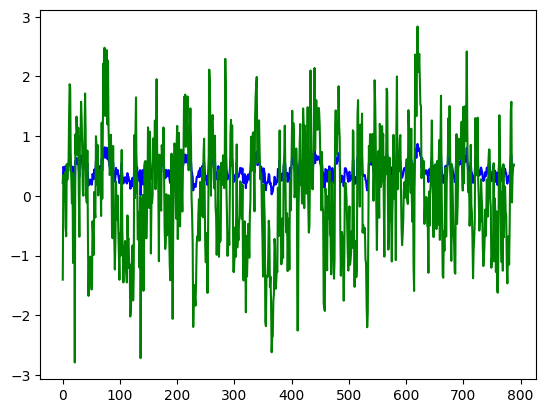

In [11]:
target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target()
plt.plot(target_df_trainVal['mean'], color='blue')
plt.plot(target_df_trainVal['mean_std'], color='green')

# features of Emiliani2

### temperature

In [22]:
path = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/features/csv_mean/daily_mean_temperature(tg)/Emiliani2_tg.csv'

colnames = ['cyclostationary_mean_tg']

aggregate_trainVal = pd.DataFrame()
aggregate_test = pd.DataFrame()

for col in colnames:
    df_train_unfolded_std,df_val_unfolded_std,df_test_unfolded_std,df_trainVal_unfolded_std = prepare_features(path,col)
    df_trainVal_unfolded_std_withTar = pd.concat((df_trainVal_unfolded_std,target_df_trainVal['mean_std']), axis=1)
    output = LinCFA(df_trainVal_unfolded_std_withTar,'mean_std', 0).compute_clusters()

    for i in range(len(output)):
        aggregate_trainVal[col+'_'+str(i)] = df_trainVal_unfolded_std_withTar[output[i]].mean(axis=1)
        aggregate_test[col+'_'+str(i)] = df_test_unfolded_std[output[i]].mean(axis=1)
    
    print(len(output))
    
aggregate_trainVal    
    

AttributeError: 'DataFrame' object has no attribute 'x'

In [20]:
df = pd.read_csv(path)
df.rename(columns={'Unnamed: 0':'date'})

,date,mean,year,week,cyclostationary_mean
0,2001-01-05,2.305135,2001,1,0.560024
1,2001-01-13,5.310077,2001,2,3.357927
2,2001-01-21,0.675788,2001,3,-0.945032
3,2001-01-29,4.229442,2001,5,2.552268
4,2001-02-06,3.730202,2001,6,0.665864
...,...,...,...,...,...
976,2022-05-23,21.827153,2022,21,4.624119
977,2022-05-31,20.665490,2022,22,2.601352
978,2022-06-08,22.102288,2022,23,3.769107
979,2022-06-16,22.400644,2022,24,2.993290


In [18]:
df.columns

Index(['Unnamed: 0', 'mean', 'year', 'week', 'cyclostationary_mean'], dtype='object')

In [6]:
### temperature
path = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/features/csv_mean/daily_mean_temperature(tg)/Emiliani2_tg.csv'

temp_df_train_unfolded_std,temp_df_val_unfolded_std,temp_df_test_unfolded_std,temp_df_trainVal_unfolded_std = prepare_features(path)

### with the new class
temp_df_trainVal_unfolded_std_withTar = pd.concat((temp_df_trainVal_unfolded_std,target_df_trainVal['mean_std']), axis=1)
temp_output = LinCFA(temp_df_trainVal_unfolded_std_withTar,'mean_std', 0).compute_clusters()
temp_output

temp_aggregate_trainVal = pd.DataFrame()
temp_aggregate_test = pd.DataFrame()

for i in range(len(temp_output)):
    print(len(temp_output[i]))
    temp_aggregate_trainVal[str(i)] = temp_df_trainVal_unfolded_std_withTar[temp_output[i]].mean(axis=1)
    temp_aggregate_test[str(i)] = temp_df_test_unfolded_std[temp_output[i]].mean(axis=1)
    
print(len(temp_output))

regr = LinearRegression()
regr = regr.fit(temp_aggregate_trainVal,target_df_trainVal['mean_std'])
regr.score(temp_aggregate_test,target_df_test['mean_std'][:-7])

KeyError: 'date'

### Precipitation

In [18]:
### precipitation
path='/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/features/csv_allvalues/daily_precipitation_sum(rr)/Emiliani2_rr.csv'
prec_df_train_unfolded_std,prec_df_val_unfolded_std,prec_df_test_unfolded_std,prec_df_trainVal_unfolded_std = prepare_features(path)

### with the new class
prec_df_trainVal_unfolded_std_withTar = pd.concat((prec_df_trainVal_unfolded_std,target_df_trainVal['mean_std']), axis=1)
prec_output = LinCFA(prec_df_trainVal_unfolded_std_withTar,'mean_std', 0).compute_clusters()
prec_output

prec_aggregate_trainVal = pd.DataFrame()
prec_aggregate_test = pd.DataFrame()

for i in range(len(prec_output)):
    print(len(prec_output[i]))
    prec_aggregate_trainVal[str(i)] = prec_df_trainVal_unfolded_std_withTar[prec_output[i]].mean(axis=1)
    prec_aggregate_test[str(i)] = prec_df_test_unfolded_std[prec_output[i]].mean(axis=1)
    
print(len(prec_output))

regr = LinearRegression()
regr = regr.fit(prec_aggregate_trainVal,target_df_trainVal['mean_std'])
regr.score(prec_aggregate_test,target_df_test['mean_std'][:-7])

1
37
1
1
3
1
16
6
1
1
4
8
5
1
29
3
1
1
2
2
2
1
1
2
24


/var/folders/h8/q6jr81l13jg__h7vcvcff1y00000gn/T/ipykernel_30756/2702166885.py:22: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  regr.score(prec_aggregate_test,target_df_test['mean_std'][:-7])


0.031084640670759334

### both

In [16]:
regr = LinearRegression()
regr = regr.fit(pd.concat((temp_aggregate_trainVal,prec_aggregate_trainVal),axis=1),target_df_trainVal['mean_std'])
regr.score(pd.concat((temp_aggregate_test,prec_aggregate_test),axis=1),target_df_test['mean_std'][:-7])

/var/folders/h8/q6jr81l13jg__h7vcvcff1y00000gn/T/ipykernel_30756/802910874.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  regr.score(pd.concat((temp_aggregate_test,prec_aggregate_test),axis=1),target_df_test['mean_std'][:-7])


0.061283170545682